In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.use("TkAgg")
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
import os
import warnings

warnings.filterwarnings("ignore", category=UserWarning)


%matplotlib inline 

# GOES lectura archivos netCDF 

Este formato de datos es un marco desarrollado para la información desarrollada en geociencias. Python tiene una biblioteca dedicada a manejar archivos *netCDF4*, que es el formato de archivo de los datos obtenidos en el GOES-16. Vamos a leer un archivo al mismo nivel de este Notebook 

In [9]:
%ls

ABI-L2-LSTM_2019_339_17_OR_ABI-L2-LSTM1-M6_G16_s20193391700271_e20193391700328_c20193391700579.nc
ABI-L2-LSTM_2019_350_23_OR_ABI-L2-LSTM1-M6_G16_s20193502300254_e20193502300312_c20193502300552.nc
ABI-L2-LSTM_2019_350_23_OR_ABI-L2-LSTM2-M6_G16_s20193502300525_e20193502300583_c20193502301218.nc
Untitled.ipynb


In [10]:
f1 = "ABI-L2-LSTM_2019_339_17_OR_ABI-L2-LSTM1-M6_G16_s20193391700271_e20193391700328_c20193391700579.nc"
f2 = "ABI-L2-LSTM_2019_350_23_OR_ABI-L2-LSTM1-M6_G16_s20193502300254_e20193502300312_c20193502300552.nc"
f3 = "ABI-L2-LSTM_2019_350_23_OR_ABI-L2-LSTM2-M6_G16_s20193502300525_e20193502300583_c20193502301218.nc"

nc = Dataset(f1,mode = "r")

Estos tipos de archivos tienen varias opciones para poder explorar. La primera lectura importante del archivo netCDF es la variable "resumen" que se puede imprimir usando *file.summary*

In [11]:
nc.summary

"The Land Surface (Skin) Temperature product consists of pixels containing the skin temperatures for each 'clear' or 'probably clear' land surface pixel. This product is generated from a regression algorithm that linearly combines ABI surface emissivity data, brightness temperature, and brightness temperature differences derived from top of atmosphere radiances from ABI bands with wavelengths 11.19 and 12.27 um. Product data is generated both day and night."

**La temperatura de superficie terrestre consta de píxeles que contienen las temperatura de la superficie para cada píxel de superficie terrestre 'claro' o probablemente 'claro'. Este producto se genera a partir de un algoritmo de regresión que combina linealmente datos de emisividad de superficie ABI, temperatura de brillo y diferencias de temperatura de brillo derivadas de las radiaciones de la parte superior de la atmósfera de las bandas ABI con las longitudes de 11.29 y 12.27 $\mu m$. Los datos del producto se generan tanto de dia como de noche**

Luego se puede imprimir todas las variables disponibles en el archivo para comprender cómo se estructuran los datos. Lo hacemos de la siguiente manera


In [12]:
for i in nc.variables: print(i)

LST
DQF
t
y
x
time_bounds
goes_imager_projection
y_image
y_image_bounds
x_image
x_image_bounds
nominal_satellite_subpoint_lat
nominal_satellite_subpoint_lon
nominal_satellite_height
geospatial_lat_lon_extent
retrieval_local_zenith_angle
quantitative_local_zenith_angle
retrieval_local_zenith_angle_bounds
quantitative_local_zenith_angle_bounds
solar_zenith_angle
solar_zenith_angle_bounds
total_pixels_where_lst_is_retrieved
number_good_retrievals
outlier_pixel_count
min_lst
max_lst
mean_lst
standard_deviation_lst
algorithm_dynamic_input_data_container
processing_parm_version_container
algorithm_product_version_container
percent_uncorrectable_GRB_errors
percent_uncorrectable_L0_errors


La variable **LST** es la temperatura de la superficie. **DQF** representa un indicador de calidad de datos, la cual es la determinacion de la calidad del valor de píxle **LST** individual. La variable **t** indican el punto intermedio en el tiempo entre el comienzo y el final en la toma del tiempo de los datos **time_bounds**. 

Las variables **x** e **y** representan la proyección de cuadricula fija GOES de las coordendas **x** e **y** en radianes. Estas coordenadas pueden proyectarse para producir la cuadricula completa necesaria para trazar cada píxel LST en un mapa geográfico. La variable final que vamos a revisar **goes_imager_projection**, es vital para convertir nuestras coordenadas **x** e **y** de radianes a valores reales de latitud y longotud. Afortunadamente, esto se ha hecho para en el archivo .nc

In [13]:
nc.variables["LST"].units

'K'

Otra parte fundamental en el análisis es la libreria ***Basemap**. Esencial para visualizar imágenes de satélite y trazar datos sobre vectores llamados archivos de forma que representan países, cuerpos de agua y otros límites geográficos significativos. A continuación se muestra un códiog de mapeo simple del archivo

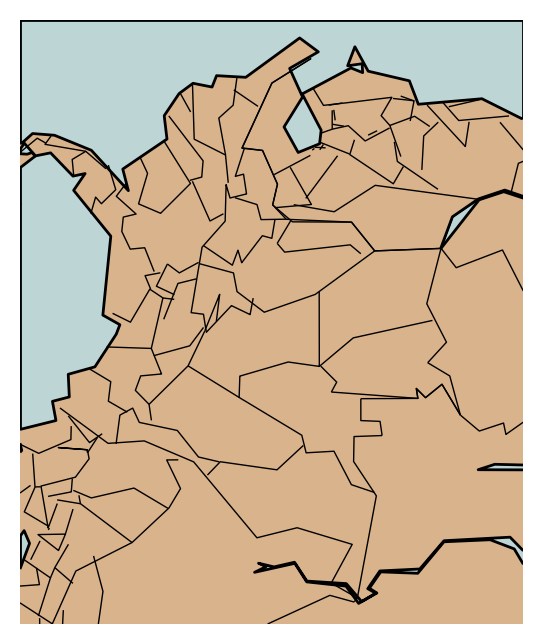

In [77]:
# limites
bbox = [-80,-5,-65,13] 
# configuración figura
fig, ax = plt.subplots(figsize=(9,4),dpi =200)
ax.set_axis_off()
m = Basemap(llcrnrlon=bbox[0],llcrnrlat=bbox[1],urcrnrlon=bbox[2],urcrnrlat=bbox[3],projection="cyl")
m.fillcontinents(color='#d9b38c',lake_color='#bdd5d5') # continent colors
m.drawmapboundary(fill_color='#bdd5d5') # ocean color
m.drawcoastlines() 
m.drawcountries()
states = m.drawstates() # draw state boundaries
parallels = np.linspace(bbox[0],bbox[2],5) # longitude lines
m.drawparallels(parallels,labels=[True,False,False,False])
meridians = np.linspace(bbox[1],bbox[3],5)  # latitude lines
m.drawmeridians(meridians,labels=[False,False,False,True])

plt.show()


### Satelite y geometría de la tierra

Los píxeles del satélite pude ser aproximado como una parte de área de la superficie de la tierra. Cada píxel es identificado por un ángulo a cierta altura sobre la tierra. El satélite produce ángulos en la dirección $x$ e $y$, al tiempo que nos proporciona información sobre la altura del instrumento e información sobre la tierra. Estos parámetros nos permitirán aproximar la latitud y longitud de cada píxel después de la extrapolación a la superficie de la tierra

Cada píxel necesita la siguiente información:

1. Considerar la tierra como un elipsoide
2. Sistema de referencia con respecto al centro de la tierra
3. Propiedades satélitales desde el punto y centro de la tierra

Se presenta un pequeño esque,a de la geometría que se considera para hacer la aproximación que involucra la proyección de la información de exploración del satélite en el sistema de coordenadas geodésicas de la tierra

<img src="elipse.png">

Ahora se hace una revisión de las ecuaciones que se necesitan para ir de las medidas proporcionadas en radianes a las coordenadas de latitud y longitud que tienen asociadas la información geográfica.

El satélite **GOES-R** produce archivo de formato **netCDF4** que contienen la información física. 

$$x = \text{horizontal [radianes]}$$
$$y = \text{vertical [radianes]}$$

Las coordenadas de proyeccion solo proporcionan información sobre el ángulo de cada píxel en referencia al generador de imágenes. Usando los ángulos de escaneo podemos derivar la cuadrícula de latitud y longitud para relacionar las variables de datos con el comportamiento del terreno. Este método crea matrices de latitud y longitud, que también ayudan en la calibración de productos satelitales, así como la integración con modelos climáticos basados en ubicaciones geográficas.

<img src="cuadricula.png">





$$x\text{[radianes]}\longrightarrow\text{latitud [grados]}$$
$$y\text{[radianes]}\longrightarrow\text{latitud [grados]}$$

### Proyección de los angulos (Radianes) a coordenadas geográficas (Latitud/Longitud)

Ahora que hemos hecho un esquema aproximado de la geometría del satélite y la tierra podemos pensar en la proyección de los datos en un matriz. A partir de este punto $x$ representa el valor de la exploración horizontal en un punto dado, $y$ representa el valor explorado en vertical en un punto dado. $\varphi$ es la latitud geodésica del punto correspondiente. La transformación que relaciona el cambio de coordenadas $(x,y) \rightarrow (\varphi,\lambda)$ está dada por



$$\varphi = \arctan\left[\frac{r^{2}_{eq}}{r^{2}_{pol}}\frac{s_{z}}{\sqrt{(H-s_{x})^{2}+s^{2}_{y}}}\right]$$

$$\lambda = \lambda_{o}-\arctan\left(\frac{s_{y}}{H-s_{x}}\right)$$

donde entemos las variables de la siguiente manera

$r_{eq}\quad \text{Radio de la tierra en el ecuador}$

$r_{pol}\quad \text{Radio de la tierra en el polo}$

$H \quad \text{Distancia del satélite al centro de la tierra}$

$\lambda_{o}\quad \text{Longitud en el origen de la proyección}$

$s_{x,y,z} \quad \text{derivado usando localización del satélite y la geometría de la tierra}$

se definen de la siguiente manera

$$s_{x} = r_{s}\cos(x)\cos(y)$$
$$s_{y} = -r_{s}\sin(x)$$
$$s_{z} = r_{s}\cos(x)\sin(y)$$

Entonces a partir de acá se define de manera conveniente para el calculo en el código las siguientes expresiones

$$a=\sin^{2}x+\cos x \left(\cos^{2}y + \frac{r^{2}_{eq}}{r^{2}_{pol}}\sin^{2}y\right)$$
$$b = -2H\cos(x)\cos(y)$$
$$c = H^{2}-r^{2}_{eq}$$

$$r_{s} = \frac{-b-\sqrt{b^{2}-4ac}}{2a}$$

Después de estas definiciones estamos listos para poder calcular la longitud y la latitud desde la información que nos da el satélite **GOES-R** a partir de 

$$\varphi = \arctan\left[\frac{r^{2}_{eq}}{r^{2}_{pol}}\frac{s_{z}}{\sqrt{(H-s_{x})^{2}+s^{2}_{y}}}\right]$$

$$\lambda = \lambda_{o}-\arctan\left(\frac{s_{y}}{H-s_{x}}\right)$$



Text(0.5, 1.0, 'Temperatura superficial')

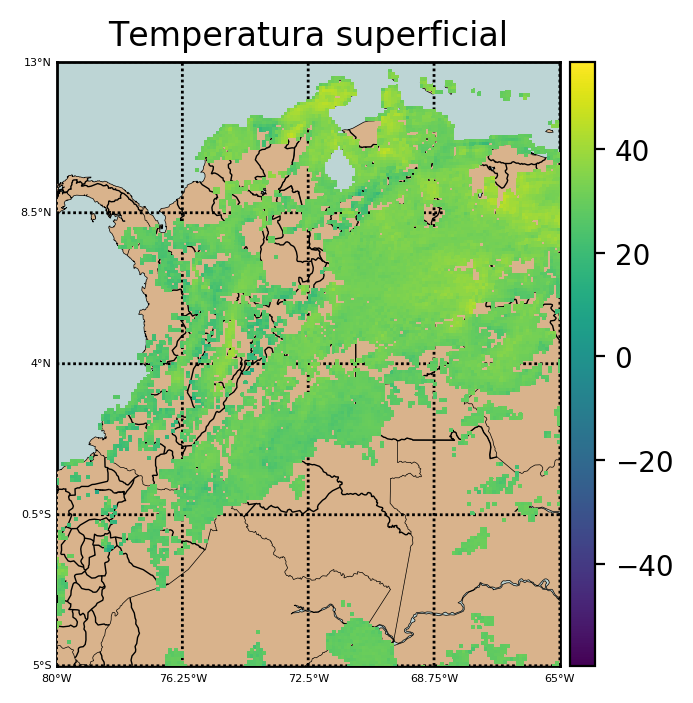

In [82]:
f1 = "ABI-L2-LSTM_2019_339_17_OR_ABI-L2-LSTM1-M6_G16_s20193391700271_e20193391700328_c20193391700579.nc"
f2 = "ABI-L2-LSTM_2019_350_23_OR_ABI-L2-LSTM1-M6_G16_s20193502300254_e20193502300312_c20193502300552.nc"
f3 = "ABI-L2-LSTM_2019_350_23_OR_ABI-L2-LSTM2-M6_G16_s20193502300525_e20193502300583_c20193502301218.nc"
f4 = "ABI-L2-LSTC_2019_339_16_OR_ABI-L2-LSTC-M6_G16_s20193391601163_e20193391603536_c20193391604414.nc"
f5 = "ABI-L2-LSTC_2019_339_17_OR_ABI-L2-LSTC-M6_G16_s20193391701163_e20193391703536_c20193391704440.nc"
f6 = "ABI-L2-LSTF_2019_339_16_OR_ABI-L2-LSTF-M6_G16_s20193391600198_e20193391609506_c20193391610450.nc"
f7 = "ABI-L2-LSTF_2019_339_18_OR_ABI-L2-LSTF-M6_G16_s20193391800196_e20193391809504_c20193391810377.nc"
nc = Dataset(f7,mode = "r")

# proyección GOES 
proy = nc.variables["goes_imager_projection"]
lon_ori = proy.longitude_of_projection_origin
H = proy.perspective_point_height + proy.semi_major_axis
r_eq = proy.semi_major_axis
r_pol = proy.semi_minor_axis
# informacion de la malla
lat_rad_1d = nc.variables["x"][:]
lon_rad_1d = nc.variables["y"][:]


lat_rad, lon_rad = np.meshgrid(lat_rad_1d,lon_rad_1d)
lo = lon_ori*np.pi/180. #transformación de la variable a grados 
a_var = np.power(np.sin(lat_rad),2.) + np.power(np.sin(lat_rad),2.0) + (np.power(np.cos(lat_rad),2.0)*\
                                             (np.power(np.cos(lon_rad),2.0)+\
                                              (((r_eq*r_eq)/(r_pol*r_pol))*\
                                               np.power(np.sin(lon_rad),2.0))))
b_var = -2.0*H*np.cos(lat_rad)*np.cos(lon_rad)
c_var = (H**2.0)-(r_eq**2.0)

r_s = (-1.0*b_var - np.sqrt(abs((b_var**2)-(4.0*a_var*c_var))))/(2.0*a_var)

s_x = r_s*np.cos(lat_rad)*np.cos(lon_rad)
s_y = - r_s*np.sin(lat_rad)
s_z = r_s*np.cos(lat_rad)*np.sin(lon_rad)

# proyeccion de latitud y longitud y se hace el plot tradicional 
lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*\
                                   ((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
lon = (lo - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)

var_names = [i for i in nc.variables]
var_name = var_names[0]
data = nc.variables[var_name][:]-273.15
data_units = nc.variables[var_name].units
data_time_grab = ((nc.time_coverage_end).replace("T",' ')).replace
data_long_name = nc.variables[var_name].long_name

data_bounds = np.where(data.data!=65535)
#bbox = [np.min(lon[data_bounds]),np.min(lat[data_bounds]),np.max(lon[data_bounds]),np.max(lat[data_bounds])]
#bbox = [-85.763068,-20.523096,-56.949895,39.384358] 
bbox = [-80,-5,-65,13] 



fig = plt.figure(figsize = (9,4), dpi = 200)
n_add = 0

m = Basemap(llcrnrlon=bbox[0]-n_add,llcrnrlat=bbox[1]-n_add,urcrnrlon=bbox[2]+n_add,urcrnrlat=bbox[3]+n_add,resolution='i', projection='cyl')
m.fillcontinents(color='#d9b38c',lake_color='#bdd5d5',zorder=1) # continent colors
m.drawmapboundary(fill_color='#bdd5d5',zorder=0) # ocean color
m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.25)
m.drawstates(zorder=2)
m.pcolormesh(lon.data, lat.data, data, latlon=True,zorder=999) # plotting actual LST data
parallels = np.linspace(bbox[1],bbox[3],5)
m.drawparallels(parallels,labels=[True,False,False,False],zorder=2,fontsize=4)
meridians = np.linspace(bbox[0],bbox[2],5)
m.drawmeridians(meridians,labels=[False,False,False,True],zorder=1,fontsize=4)
cb = m.colorbar()

plt.title("Temperatura superficial")
#data_units = ((data_units.replace('-','^{-')).replace('1','1}')).replace('2','2}')
#plt.rc('text', usetex=True)
#cb.set_label(r'%s $ \left[ \mathrm \right] $'% (var_name,data_units))
#plt.title(' on '.format(data_long_name,data_time_grab))
#plt.tight_layout()

El producto **LTS** procesado por **GOES-R** se utiliza para aplicaciones en el modelado y prediccion del clima, información en tiempo real sobre incendios y otros peligros naturales, comportamiento histórico para el análisis de cultivo, etc. 